In [35]:

from transformer_lens import HookedTransformer
from activation_additions import (
    prompt_utils,
    hook_utils,
    hyperparameter_search
)
import numpy as np

In [2]:
# %%
# Load a model
MODEL = HookedTransformer.from_pretrained(model_name="gpt2-xl", device="cpu")
_ = MODEL.to("cuda:0")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda:0


In [3]:
hyperparameter_search.conditional_perplexity(MODEL,
    MODEL.to_tokens("The only thing, that we need to fear is"),
    MODEL.to_tokens(" fear itself")[:,1:]
) 

0.8540814332664013

In [4]:
perplexity=hyperparameter_search.conditional_perplexity(MODEL,
    MODEL.to_tokens("The only thing we have to fear is"),MODEL.to_tokens(" fear itself")[:, 1:])
perplexity

0.21780490269884467

In [5]:
ActAds =[prompt_utils.ActivationAddition(coeff=4, act_name=6,prompt=" Pizza!"),
         prompt_utils.ActivationAddition(coeff=-4, act_name=6,prompt=" fear")]

In [ ]:
hyperparameter_search.completion_perplexities(
    MODEL,
    [MODEL.to_tokens("The only thing we have to fear is")],
    [MODEL.to_tokens(" fear itself")[:, 1:]],
    [MODEL.to_tokens(" Pizza!")[:, 1:]],
    ActAds
)

In [4]:
US_UK_dict = {
    "1": ["The delivery driver parked the", " lorry outside the warehouse.", " truck outside the warehouse."],
    "2": ["Can you please turn off the", " tap in the kitchen?", " faucet in the kitchen?"],
    "3": ["I recently rented my first", " flat.", " apartment."],
    "4": ["We are planning to go on a", " holiday to Europe next summer.", " vacation to Europe next summer."],
    "5": ["Would you like a", " biscuit with your tea?", " cookie with your tea?"],
    "6": ["I'm thinking of making a dish with", " aubergine tonight.", " eggplant tonight."],
    "7": ["It's getting chilly; I'll wear my", " jumper today.", " sweater today."],
    "8": ["She bought a bag of salt and vinegar", " crisps from the store.", " chips from the store."],
    "9": ["It's too dark here. Do you have a", " torch?", " flashlight?"],
    "10": ["My kids enjoy playing", " football every weekend.", " soccer every weekend."]
}


In [22]:
MODEL.remove_all_hook_fns()

In [8]:
prompts=[]
UK_completions=[]
US_completions=[]
for key, example in US_UK_dict.items():
    prompts.append(example[0])
    UK_completions.append(example[1])
    US_completions.append(example[2])

In [62]:
len(list(np.linspace(1,MODEL.cfg.n_layers-1,10,dtype=int)))

10

In [75]:
[int(i) for i in np.linspace(1,MODEL.cfg.n_layers-1,10)]

[1, 6, 11, 16, 21, 26, 31, 36, 41, 47]

In [77]:

df=hyperparameter_search.layer_coefficient_gridsearch(
    MODEL,
    prompts,
    {" British":1," American":-1},
    [int(i) for i in np.linspace(1,MODEL.cfg.n_layers-1,10)],
    [i for i in np.linspace(0,10,10,dtype=int)],
    UK_completions,
    US_completions
)

In [7]:
df=hyperparameter_search.layer_coefficient_gridsearch(
    MODEL,
    ["The only thing we have to fear is", "I feel really"],
    {" Pizza!":1," fear":-1},
    [1,2,3,4],
    [3,6,9,12],
    [" fear itself", " afraid"],
    [" Pizza!", " hungry"]
)

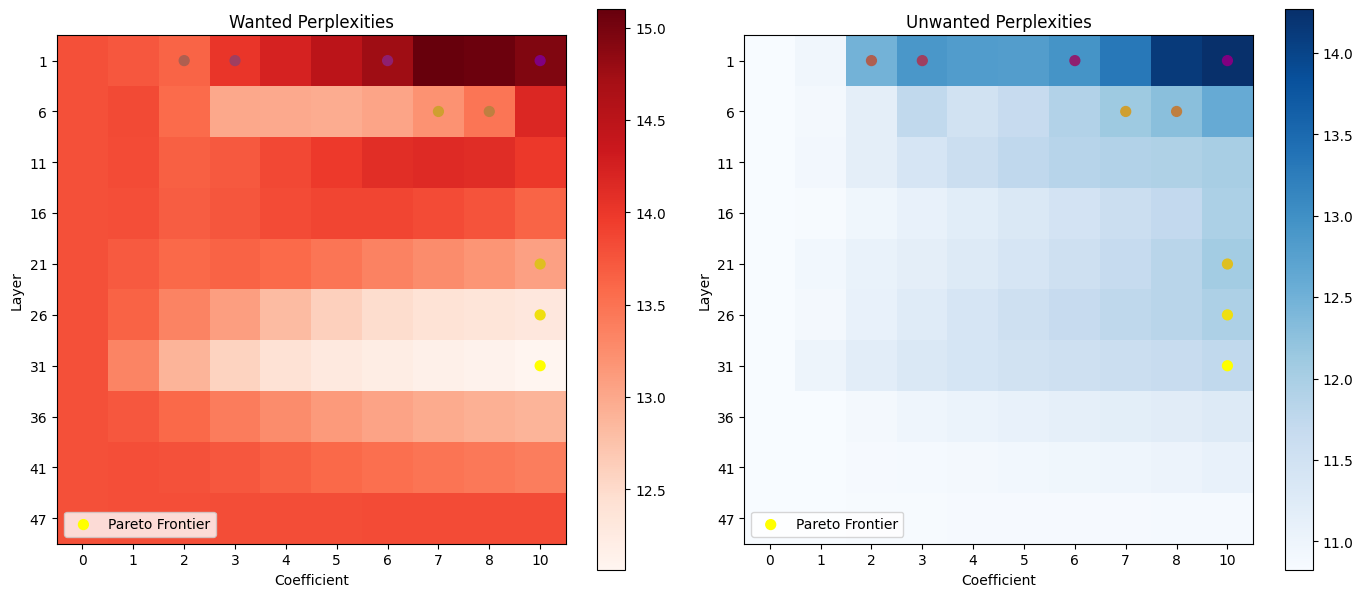

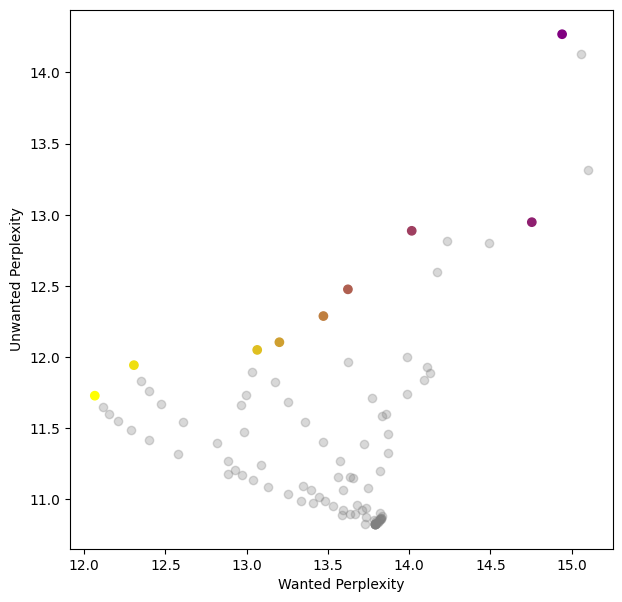

In [78]:
wanted_matrix, unwanted_matrix=hyperparameter_search.create_perplexity_matrices(df)
hyperparameter_search.plot_matrices_with_pareto(df)
hyperparameter_search.plot_pareto_frontier(wanted_matrix, unwanted_matrix)

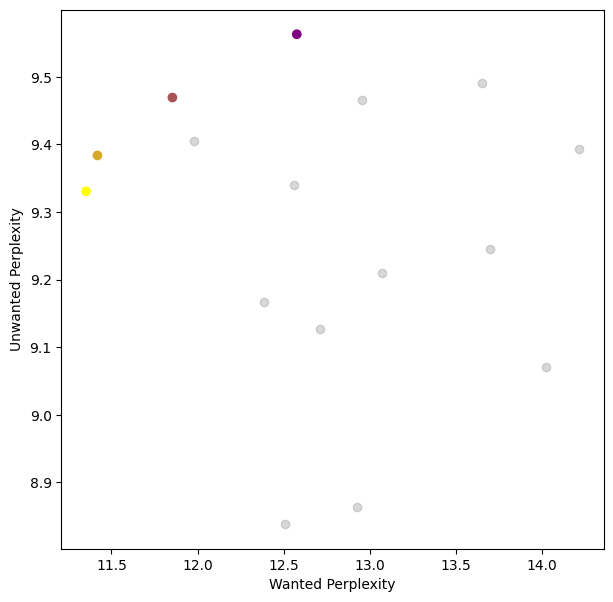

In [168]:
plot_pareto_frontier(w,u)

In [48]:
ActAds =[prompt_utils.ActivationAddition(coeff=4, act_name=6,prompt=" hate"),
         prompt_utils.ActivationAddition(coeff=-4, act_name=6,prompt=" love")]
hook_fns=hook_utils.hook_fns_from_activation_additions(MODEL, ActAds)

In [49]:
for act_name in hook_fns.keys():
    for hook_fn in hook_fns[act_name]:
        MODEL.add_hook(act_name, hook_fn)

In [31]:
default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': MODEL}
get_x_vector_preset = partial(prompt_utils.get_x_vector, pad_method="tokens_right",
                              model=MODEL,
                              custom_pad_id=MODEL.to_single_token(" "))
steering_vector=[*get_x_vector_preset(prompt1="hello", prompt2="bye", coeff=2, act_name=2)]

In [32]:
hook_fns=hook_utils.hook_fns_from_activation_additions(MODEL, steering_vector)

In [27]:
#hook_fns =hook_utils.hook_fns_from_rich_prompts(model=MODEL, rich_prompts=steering_vector)

AttributeError: module 'activation_additions.hook_utils' has no attribute 'hook_fns_from_rich_prompts'

In [55]:
for act_name, hook_fn in hook_fns.items():
    print(type(act_name))
    print(act_name)
    print(type(hook_fn))
    print(hook_fn[1])
    #MODEL.add_hook(act_name, hook_fn[0])

<class 'str'>
blocks.6.hook_resid_pre
<class 'list'>
<function hook_fn_from_activations.<locals>.prompt_hook at 0x7f433c5a4ca0>


In [41]:
name="blocks.2.hook_resid_pre"
for hook_fn in hook_fns[name]:
    print(type(hook_fn))
    MODEL.add_hook(name, hook_fn)

<class 'function'>
<class 'function'>


In [42]:
tokens=MODEL.to_tokens("Hello workd")[0]

In [37]:
MODEL.remove_all_hook_fns()

In [53]:

gpt2_logits, gpt2_cache = MODEL.run_with_cache(tokens)


In [20]:
hook

NameError: name 'hook' is not defined